<a href="https://colab.research.google.com/github/wiz124/chem169-git/blob/main/Li_Harry_RID_010_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

failed to parse 0 molecules


,Entry,Steroid_SMILES_grouped,molecules
0,A0A016VA76,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6c002e0>
1,A0A023EUU2,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6c00660>
2,A0A023EUU7,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6c00740>
3,A0A023FCJ4,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6c007b0>
4,A0A026WVM4,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6c00820>
...,...,...,...
1968,W5MGD7,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6a66ab0>
1969,W5N409,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6a66b20>
1970,W5P7N1,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6a66b90>
1971,W5P7N5,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,<rdkit.Chem.rdchem.Mol object at 0x7afcd6a66c00>


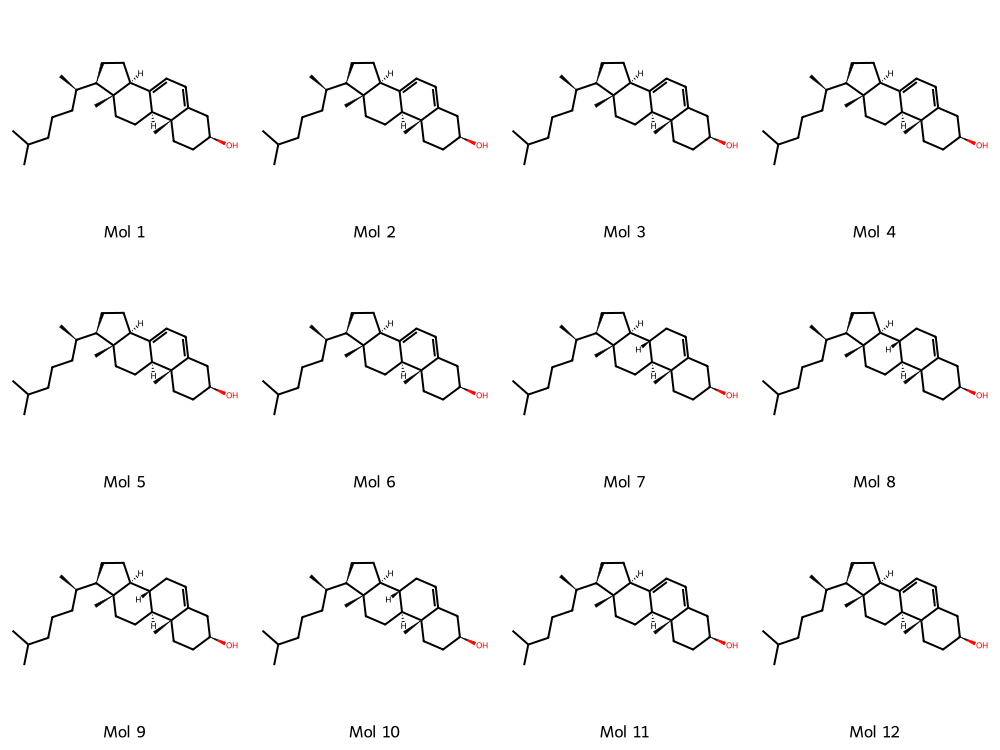

In [8]:
#Exercise 0
import pandas as pd
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('steroid_dataset - my_data.csv', usecols=['Entry','Steroid_SMILES_grouped'])

def smilestomol(smile):
    mol=Chem.MolFromSmiles(smile)
    return mol
#df['molecules']=df['Steroid_SMILES_grouped'].apply(smilestomol)
df['molecules'] = df['Steroid_SMILES_grouped'].dropna().apply(smilestomol)

none_count = sum(1 for mol in df['molecules'] if mol is None)
print(f'failed to parse {none_count} molecules')

display(df)


assert df['molecules'].dtype=='object'
assert df['molecules'].count()==df['Entry'].count()

mol_list=df['molecules'].tolist()
img = Draw.MolsToGridImage(mol_list[:12], molsPerRow=4, subImgSize=(250, 250),
                            legends=[f"Mol {i+1}" for i in range(min(12, len(mol_list)))])
img

In [16]:
#Exercise 1
from rdkit.Chem import AllChem, MACCSkeys
fingerprints={}


def fingerprint(mol_list):

  global fingerprints

  for radius in [1, 2, 3]:
    morgan_fps = []
    bit_infos = []
    for mol in mol_list:
      bit_info = {}
      fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=1024, bitInfo=bit_info)
      morgan_fps.append(fp)
      bit_infos.append(bit_info)

      fingerprints[f'Morgan_r{radius}'] = {
        'fps': morgan_fps,
        'bit_info': bit_infos
      }

def mackeyfingerprint(mol_list):
  global fingerprints
  maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mol_list]
  fingerprints['MACCS'] = {'fps': maccs_fps, 'bit_info': None}

def rdkittopological(mol_list):
  global fingerprints
  topo_fps = [Chem.RDKFingerprint(mol) for mol in mol_list]
  fingerprints['Topological'] = {'fps': topo_fps, 'bit_info': None}


with rdBase.BlockLogs():
  fingerprint(mol_list)
  mackeyfingerprint(mol_list)
  rdkittopological(mol_list)
pass


for fp_name, fp_data in fingerprints.items():
    fp = fp_data['fps'][1]
    print(f"{fp_name}:")
    print(f"  - Type: {type(fp).__name__}")
    print(f"  - Length: {len(fp)} bits")
    print(f"  - Number of on bits: {fp.GetNumOnBits()}")
    print()


Morgan_r1:
  - Type: ExplicitBitVect
  - Length: 1024 bits
  - Number of on bits: 26

Morgan_r2:
  - Type: ExplicitBitVect
  - Length: 1024 bits
  - Number of on bits: 47

Morgan_r3:
  - Type: ExplicitBitVect
  - Length: 1024 bits
  - Number of on bits: 68

MACCS:
  - Type: ExplicitBitVect
  - Length: 167 bits
  - Number of on bits: 34

Topological:
  - Type: ExplicitBitVect
  - Length: 2048 bits
  - Number of on bits: 372



In [19]:
#Exercise 2
from rdkit import DataStructs

def compute_similarity_matrix(fps):
    n = len(fps)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

    return similarity_matrix

similarity_matrices = {}

for fp_name, fp_data in fingerprints.items():
    sim_matrix = compute_similarity_matrix(fp_data['fps'])
    similarity_matrices[fp_name] = sim_matrix
    print(f"Matrix shape: {sim_matrix.shape}")


# Verify similarity matrix properties
for fp_name, sim_matrix in similarity_matrices.items():
    n = sim_matrix.shape[0]
    is_square = sim_matrix.shape[0] == sim_matrix.shape[1]
    diagonal_correct = np.allclose(np.diag(sim_matrix), 1.0)
    values_in_range = np.all((sim_matrix >= 0) & (sim_matrix <= 1))

    print(f"{fp_name}:")
    print(f"Square matrix: {is_square} ({n}x{n})")
    print(f"Diagonal = 1.0: {diagonal_correct}")
    print(f"Values in [0,1]: {values_in_range}")

Matrix shape: (1973, 1973)
Matrix shape: (1973, 1973)
Matrix shape: (1973, 1973)
Matrix shape: (1973, 1973)
Matrix shape: (1973, 1973)
Morgan_r1:
Square matrix: True (1973x1973)
Diagonal = 1.0: True
Values in [0,1]: True
Morgan_r2:
Square matrix: True (1973x1973)
Diagonal = 1.0: True
Values in [0,1]: True
Morgan_r3:
Square matrix: True (1973x1973)
Diagonal = 1.0: True
Values in [0,1]: True
MACCS:
Square matrix: True (1973x1973)
Diagonal = 1.0: True
Values in [0,1]: True
Topological:
Square matrix: True (1973x1973)
Diagonal = 1.0: True
Values in [0,1]: True


Top 5 most common bits in Morgan radius=2:

  Bit  301: appears in 1973/1973 molecules (100.0%)
  Bit  926: appears in 1973/1973 molecules (100.0%)
  Bit 1019: appears in 1973/1973 molecules (100.0%)
  Bit  233: appears in 1947/1973 molecules (98.7%)
  Bit  807: appears in 1947/1973 molecules (98.7%)
🔍 Visualizing substructures for top 3 bits (Morgan r=2)


Bit 301 (appears in 1973 molecules)



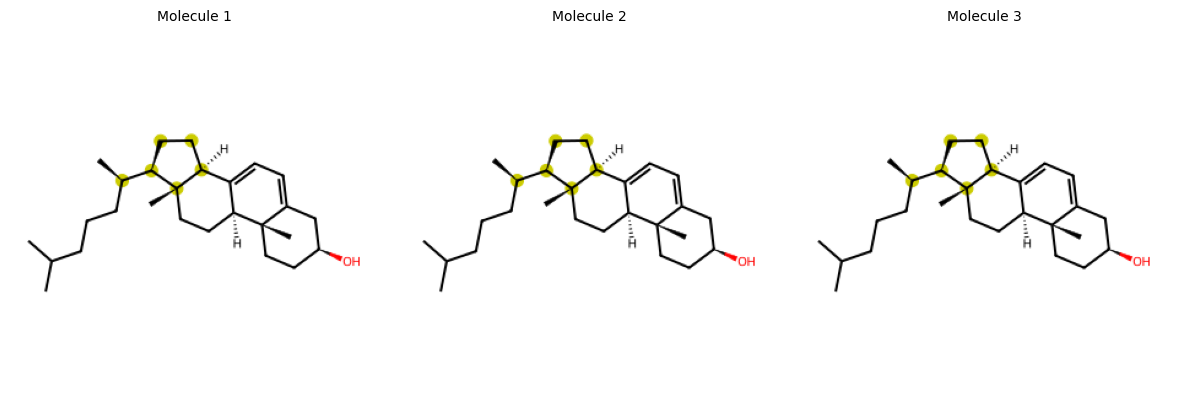


Bit 926 (appears in 1973 molecules)



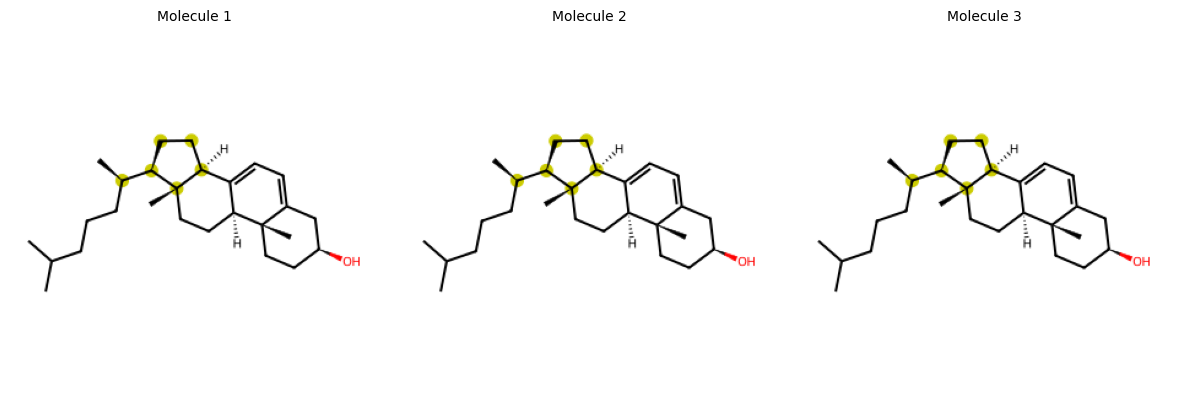


Bit 1019 (appears in 1973 molecules)



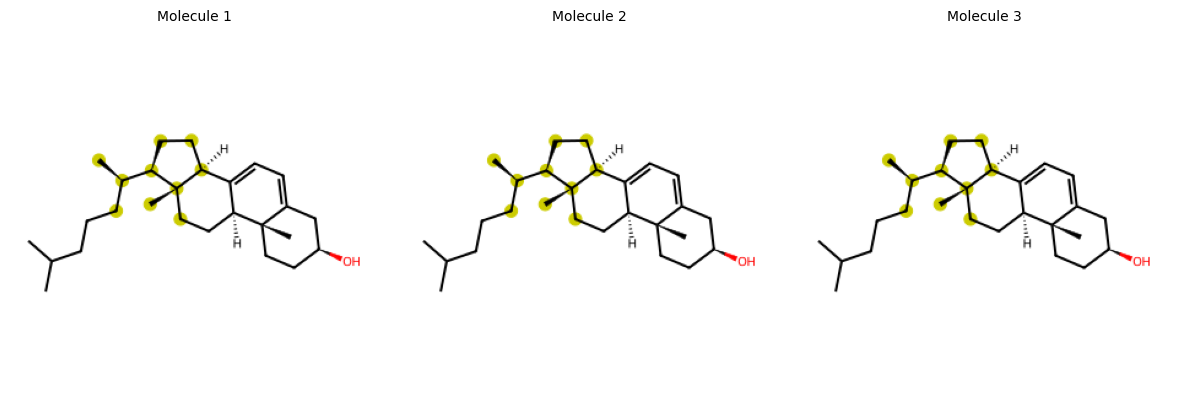

In [18]:
#Exercise 3
def find_common_bits(bit_info_list, top_n=5):
    bit_counts = {}

    for bit_info in bit_info_list:
        for bit in bit_info.keys():
            bit_counts[bit] = bit_counts.get(bit, 0) + 1

    # Sort by count (descending)
    sorted_bits = sorted(bit_counts.items(), key=lambda x: x[1], reverse=True)

    return sorted_bits[:top_n]

def visualize_bit_substructure(mol, bit_info, bit_idx, radius):
    if bit_idx in bit_info:
        # Get the atom environments for this bit
        atom_envs = bit_info[bit_idx]

        # Take the first occurrence
        center_atom, rad = atom_envs[0]

        # Get the environment
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, center_atom)

        # Get atoms to highlight
        atoms_to_highlight = []
        for bond_idx in env:
            bond = mol.GetBondWithIdx(bond_idx)
            atoms_to_highlight.extend([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        atoms_to_highlight.append(center_atom)
        atoms_to_highlight = list(set(atoms_to_highlight))

        # Draw with highlighting
        img = Draw.MolToImage(mol, size=(300, 300),
                             highlightAtoms=atoms_to_highlight,
                             highlightColor=(0.8, 0.8, 0))
        return img
    else:
        return None
# Find common bits for Morgan radius=2
radius = 2
bit_info_list = fingerprints[f'Morgan_r{radius}']['bit_info']
common_bits = find_common_bits(bit_info_list, top_n=5)

print(f"Top 5 most common bits in Morgan radius={radius}:\n")
for bit, count in common_bits:
    print(f"  Bit {bit:4d}: appears in {count}/{len(mol_list)} molecules ({count/len(mol_list)*100:.1f}%)")
# Visualize substructures for the top 3 common bits
radius = 2
bit_info_list = fingerprints[f'Morgan_r{radius}']['bit_info']
common_bits = find_common_bits(bit_info_list, top_n=3)

print(f"🔍 Visualizing substructures for top 3 bits (Morgan r={radius})\n")

for bit_idx, count in common_bits:
    print(f"\n{'='*60}")
    print(f"Bit {bit_idx} (appears in {count} molecules)")
    print(f"{'='*60}\n")

    # Find first 3 molecules that have this bit
    images = []
    mol_indices = []

    for i, bit_info in enumerate(bit_info_list):
        if bit_idx in bit_info and len(images) < 3:
            img = visualize_bit_substructure(mol_list[i], bit_info, bit_idx, radius)
            if img is not None:
                images.append(img)
                mol_indices.append(i)

    # Display the images
    if images:
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
        if len(images) == 1:
            axes = [axes]

        for ax, img, mol_idx in zip(axes, images, mol_indices):
            ax.imshow(img)
            ax.set_title(f"Molecule {mol_idx + 1}", fontsize=10)
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("  (No visualizations available)")


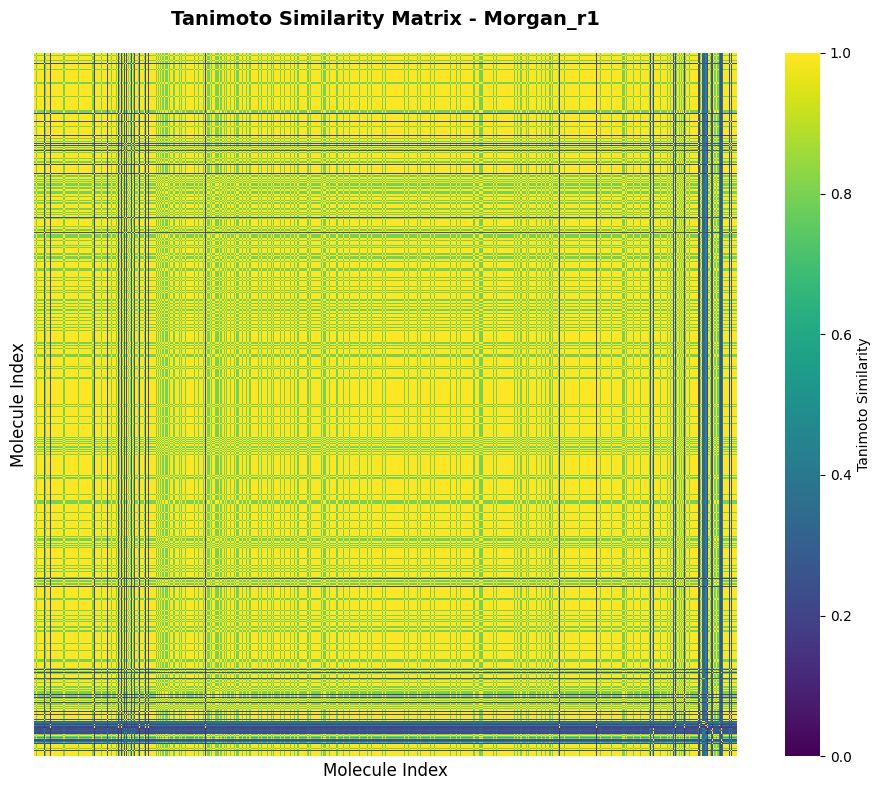

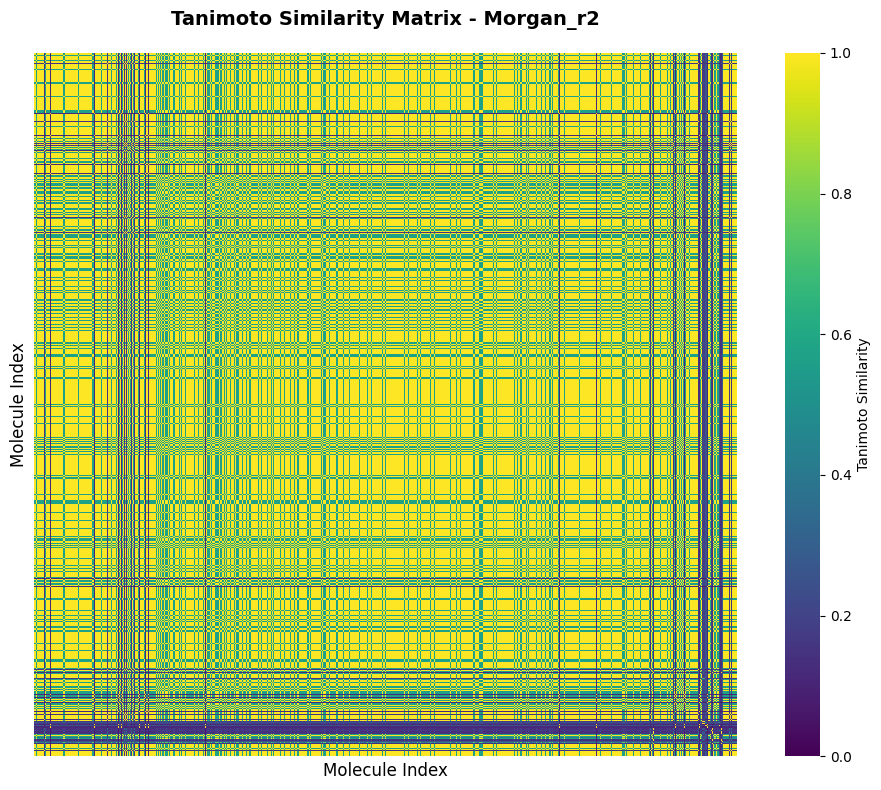

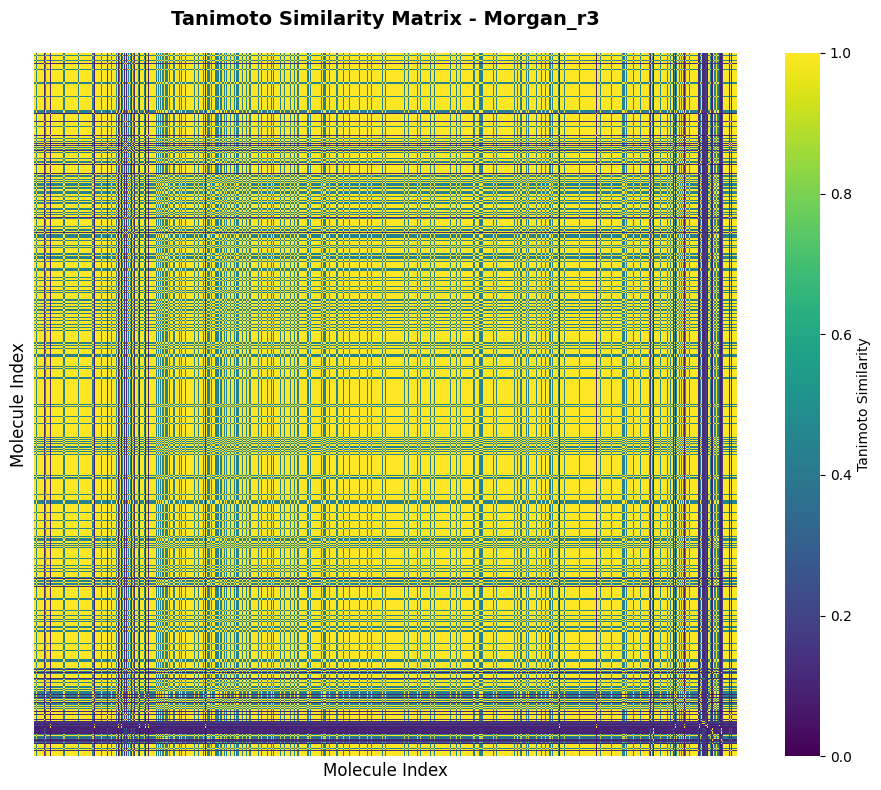

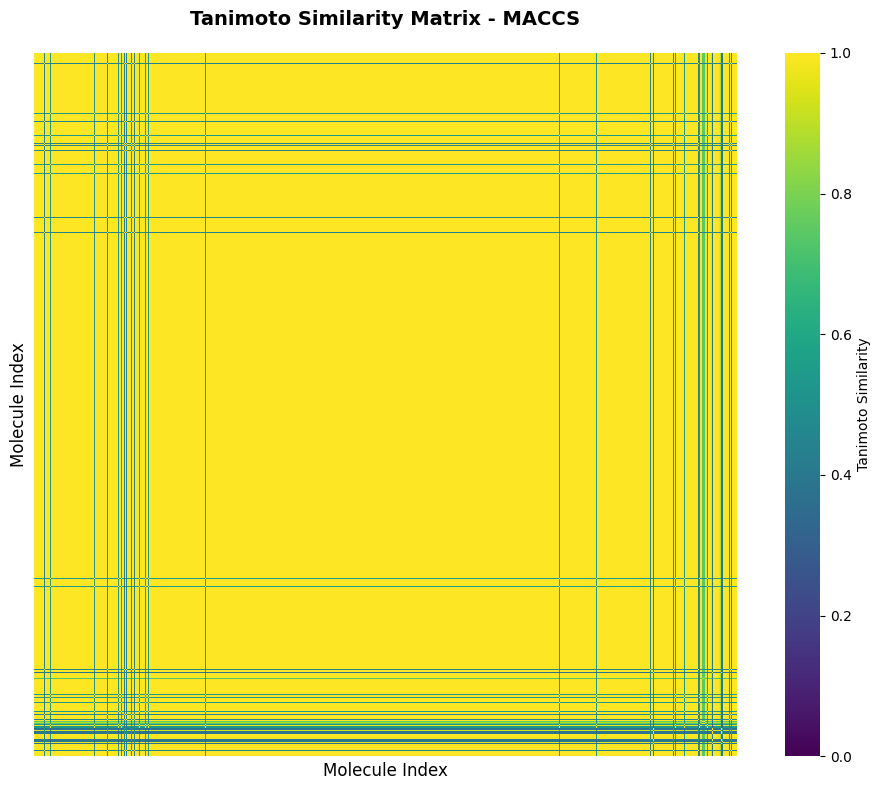

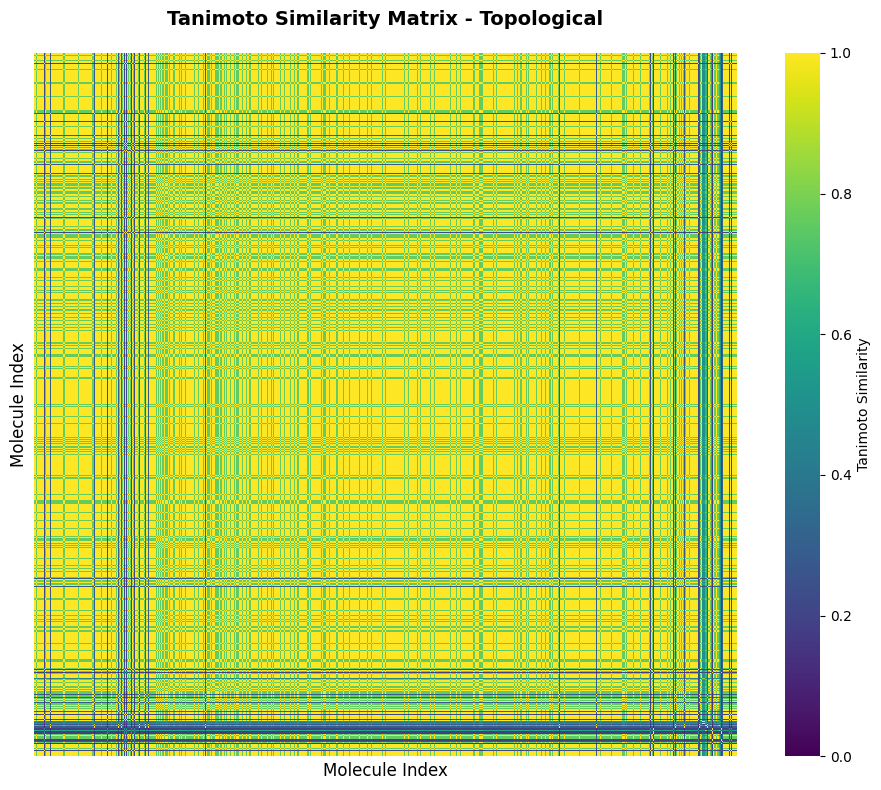

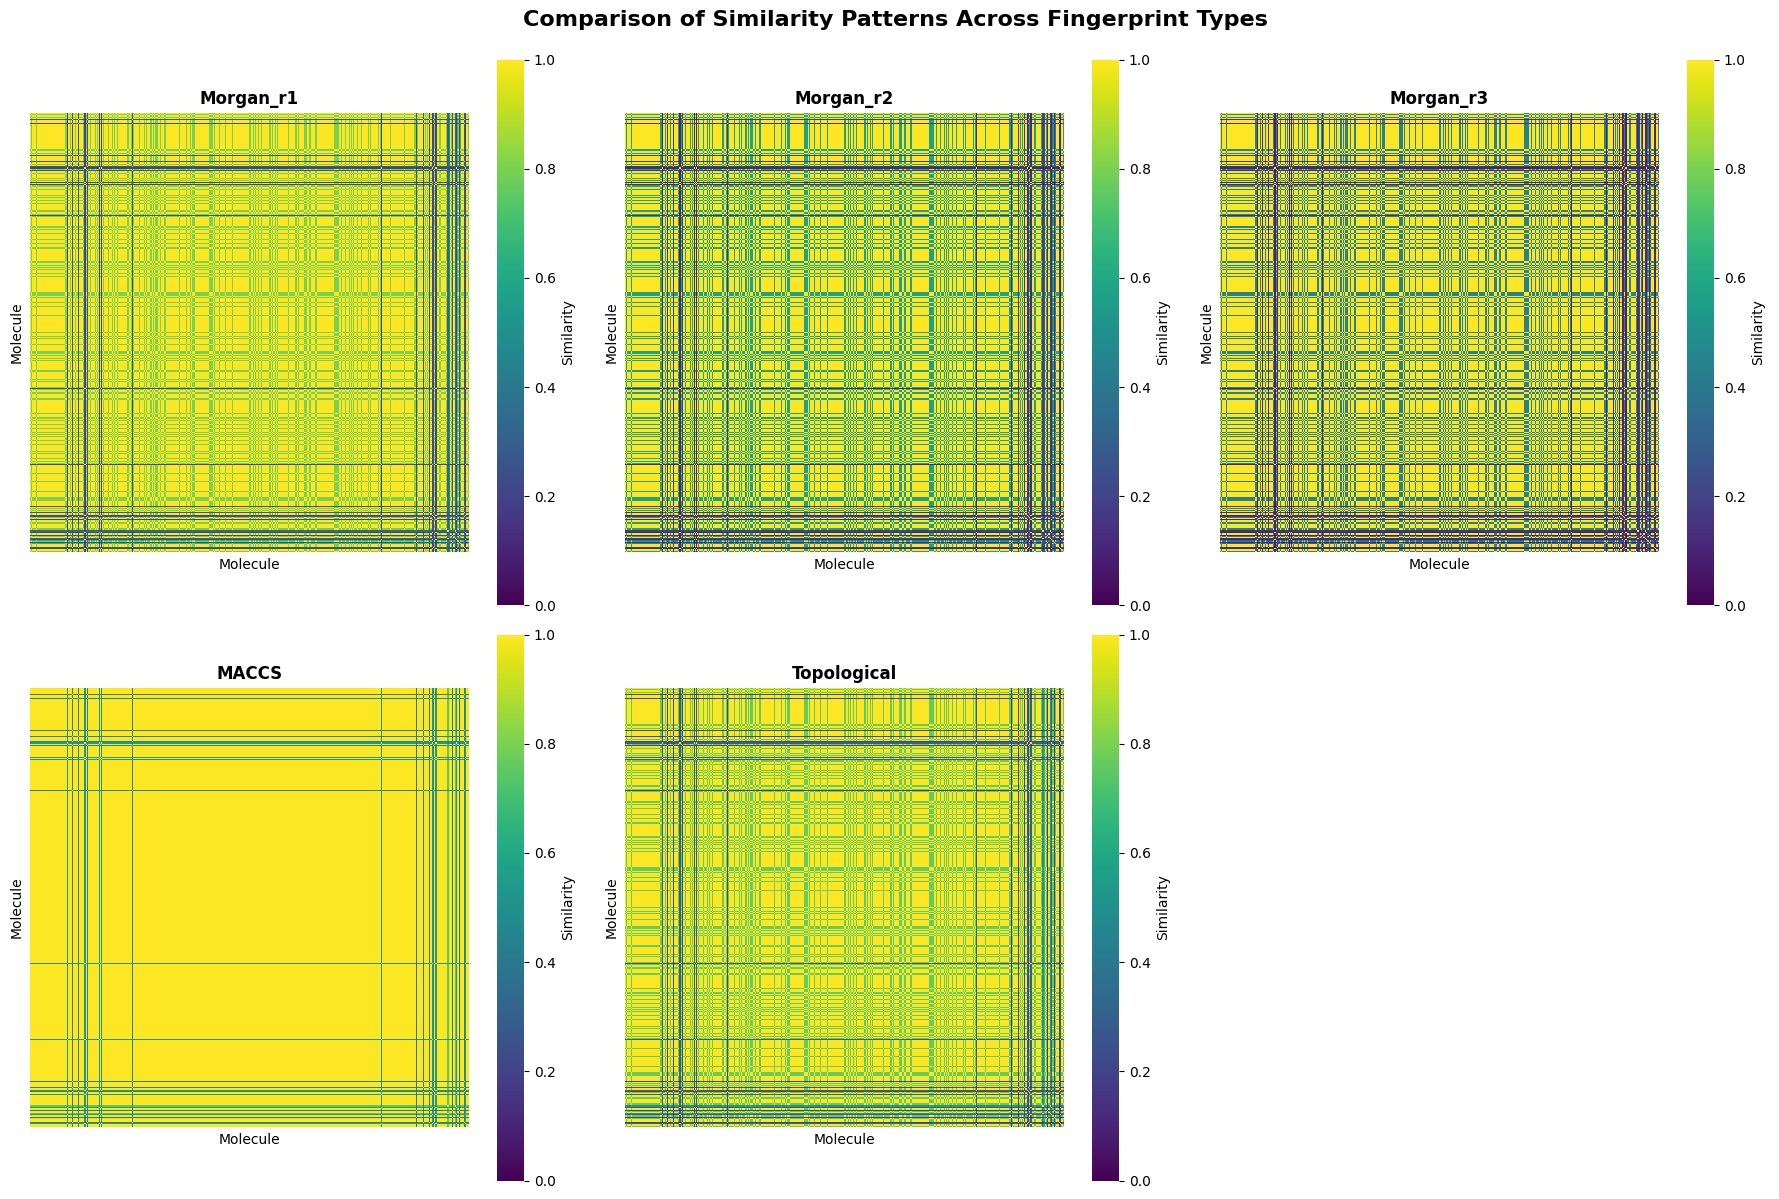

📊 Fingerprint Comparison Statistics

Fingerprint          Mean Sim     Std Dev      Median      
Morgan_r1            0.8572       0.2224       1.0000      
Morgan_r2            0.7703       0.2856       1.0000      
Morgan_r3            0.7209       0.3282       1.0000      
MACCS                0.9534       0.1464       1.0000      
Topological          0.8481       0.2192       1.0000      


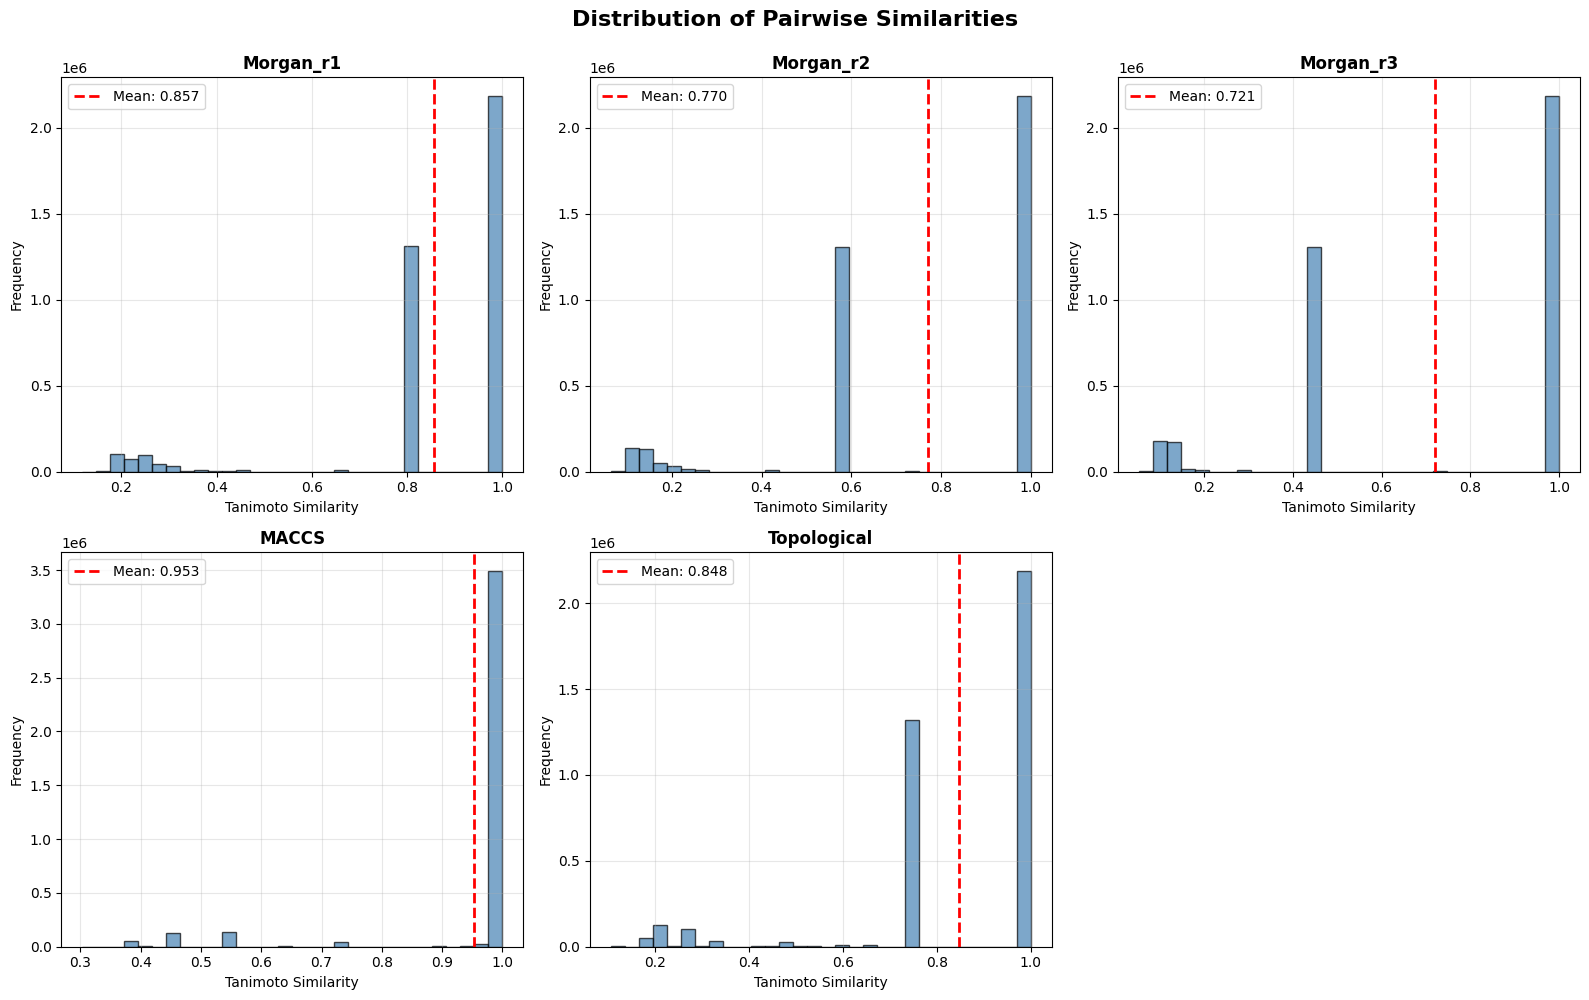

In [22]:
def plot_similarity_heatmap(similarity_matrix, title, labels=None, figsize=(10, 8)):
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(similarity_matrix,
                cmap='viridis',
                vmin=0, vmax=1,
                square=True,
                cbar_kws={'label': 'Tanimoto Similarity'},
                xticklabels=labels if labels else False,
                yticklabels=labels if labels else False)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Molecule Index', fontsize=12)
    plt.ylabel('Molecule Index', fontsize=12)
    plt.tight_layout()
    plt.show()

# Create labels for molecules (first 10 chars of SMILES for brevity)
labels = [f"M{i+1}" for i in range(len(mol_list))]

# Plot heatmaps for all fingerprint types
for fp_name, sim_matrix in similarity_matrices.items():
    plot_similarity_heatmap(
        sim_matrix,
        title=f"Tanimoto Similarity Matrix - {fp_name}",
        labels=None,  # Set to labels to show molecule IDs
        figsize=(10, 8)
    )
# Compare all fingerprint types side-by-side
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

fp_names_ordered = ['Morgan_r1', 'Morgan_r2', 'Morgan_r3', 'MACCS', 'Topological']

for idx, fp_name in enumerate(fp_names_ordered):
    if idx < len(axes) and fp_name in similarity_matrices:
        sim_matrix = similarity_matrices[fp_name]

        sns.heatmap(sim_matrix,
                   cmap='viridis',
                   vmin=0, vmax=1,
                   square=True,
                   cbar=True,
                   cbar_kws={'label': 'Similarity'},
                   xticklabels=False,
                   yticklabels=False,
                   ax=axes[idx])

        axes[idx].set_title(fp_name, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Molecule', fontsize=10)
        axes[idx].set_ylabel('Molecule', fontsize=10)

# Hide the last subplot (6th position)
if len(fp_names_ordered) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Comparison of Similarity Patterns Across Fingerprint Types',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Analyze and compare fingerprint statistics
print("📊 Fingerprint Comparison Statistics\n")
print(f"{'Fingerprint':<20} {'Mean Sim':<12} {'Std Dev':<12} {'Median':<12}")
print("="*60)

for fp_name in fp_names_ordered:
    if fp_name in similarity_matrices:
        sim_matrix = similarity_matrices[fp_name]

        # Exclude diagonal (self-similarity)
        mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
        off_diagonal = sim_matrix[mask]

        mean_sim = off_diagonal.mean()
        std_sim = off_diagonal.std()
        median_sim = np.median(off_diagonal)

        print(f"{fp_name:<20} {mean_sim:<12.4f} {std_sim:<12.4f} {median_sim:<12.4f}")
# Distribution of similarities for each fingerprint type
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, fp_name in enumerate(fp_names_ordered):
    if idx < len(axes) and fp_name in similarity_matrices:
        sim_matrix = similarity_matrices[fp_name]

        # Exclude diagonal
        mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
        off_diagonal = sim_matrix[mask]

        axes[idx].hist(off_diagonal, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        axes[idx].axvline(off_diagonal.mean(), color='red', linestyle='--',
                         linewidth=2, label=f'Mean: {off_diagonal.mean():.3f}')
        axes[idx].set_title(fp_name, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Tanimoto Similarity', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Hide the last subplot
if len(fp_names_ordered) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Distribution of Pairwise Similarities',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()